## Regression 

I will use an hourly dataset of weather in Spain together with an hourly dataset of energy generation. The data have been downloaded from https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather. The goal is to predict renewable energy (solar + wind + hydro) generation from weather.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Read data:

In [2]:
weather = pd.read_csv('../data/weather_features.csv')
energy = pd.read_csv('../data/energy_dataset.csv')
energy['total load'] = energy['generation solar'] + energy['generation wind onshore'] + energy['generation hydro run-of-river and poundage']

### Feature engineering

I have these features for weather:

In [3]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [4]:
weather['weather_main'].unique()

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [5]:
weather['city_name'].unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

I drop duplicates, a few not useful features (also pressure which upon inspection turned out to be rubbish) and the rows with missing values.

<AxesSubplot:>

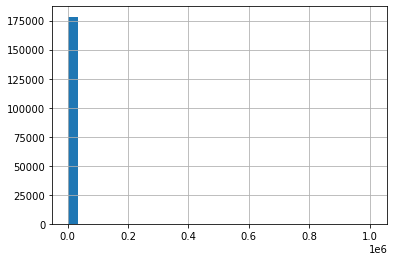

In [6]:
weather['pressure'].hist(bins=30)

In [7]:
weather.drop_duplicates(subset = 'dt_iso', inplace = True)
weather.reset_index(inplace = True)
weather.drop(columns=['city_name','temp_min','temp_max','pressure','rain_1h','rain_3h','snow_3h','wind_deg',
                      'weather_id','weather_description','weather_icon'], inplace = True)
weather.dropna(inplace = True)

Before calculating averages, I must transform the weather description to numeric through one-hot encoding.

In [8]:
Data = pd.get_dummies(data = weather, columns = ['weather_main'], drop_first = True)

Now I can calculate averages across stations.

In [9]:
Data = Data.groupby('dt_iso').mean()
Data.drop(columns = ['index'], inplace = True)

I add columns for year and date.

In [10]:
Data['dt'] = pd.to_datetime(Data.index, utc = True)
energy['dt'] = pd.to_datetime(energy['time'], utc = True)
Data['year'] = Data['dt'].dt.year
Data['date'] = Data['dt'].dt.date
energy['date'] = energy['dt'].dt.date

Finally, it is time to calculate daily values.

In [11]:
Daily = Data.groupby(['date']).mean()

In [12]:
Daily = Data.groupby(['date']).mean()
Daily['total load'] = energy['total load'].groupby([energy['date']]).sum()
Daily.dropna(subset = ['total load'], inplace = True)
#Daily['total load'] = Daily['total load'] * 24
Daily = Daily[Daily.year>2014] # drop the first row because it has a different year

Despite being daily sums, the targed variable still has a significantly non-normal distribution, which could not be sufficiently improved through a Box cox transformation.

<AxesSubplot:>

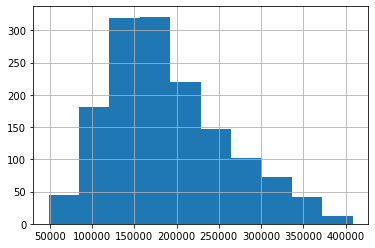

In [13]:
Daily['total load'].hist()

In [14]:
from scipy.stats.mstats import normaltest
from scipy.stats import boxcox
normaltest(Daily['total load'])

NormaltestResult(statistic=90.65396973813878, pvalue=2.0641468447721497e-20)

In [15]:
Daily['total load'] = boxcox(Daily['total load'])[0]
normaltest(Daily['total load'])

NormaltestResult(statistic=27.53138970014174, pvalue=1.0510773732624366e-06)

<AxesSubplot:>

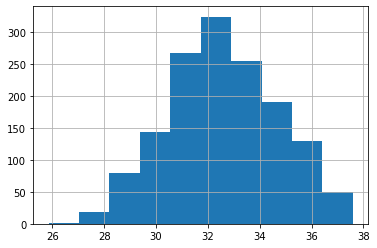

In [16]:
Daily['total load'].hist()

In [17]:
Daily.describe()

,temp,humidity,wind_speed,clouds_all,weather_main_clouds,weather_main_drizzle,weather_main_fog,weather_main_haze,weather_main_mist,weather_main_rain,weather_main_smoke,weather_main_thunderstorm,year,total load
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.00000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,290.784296,65.093450,2.692506,20.740475,0.494638,0.00134,0.001198,0.000086,0.005219,0.050679,0.000171,0.003708,2016.499658,32.586028
std,6.243922,13.036831,1.735735,19.225932,0.312441,0.00922,0.016422,0.002437,0.030496,0.149166,0.004874,0.021984,1.118111,2.101487
min,275.986987,24.750000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000,25.850897
25%,285.578333,56.250000,1.666667,6.666667,0.250000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000,31.145008
50%,290.391021,65.916667,2.250000,15.208333,0.541667,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000,32.475538
75%,296.126250,73.791667,3.041667,29.791667,0.750000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,34.088611
max,304.311417,99.541667,24.875000,92.250000,1.000000,0.12500,0.416667,0.083333,0.458333,1.000000,0.166667,0.375000,2018.000000,37.593212


In [18]:
Daily.head()

,temp,humidity,wind_speed,clouds_all,weather_main_clouds,weather_main_drizzle,weather_main_fog,weather_main_haze,weather_main_mist,weather_main_rain,weather_main_smoke,weather_main_thunderstorm,year,total load
date,,,,,,,,,,,,,,
2015-01-01,275.986987,69.958333,1.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,31.569237
2015-01-02,276.784833,67.708333,1.125000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,36.184243
2015-01-03,279.203802,70.000000,1.833333,2.5,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,35.235578
2015-01-04,279.260000,75.250000,1.333333,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,35.358938
2015-01-05,278.757313,80.833333,1.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,31.945297


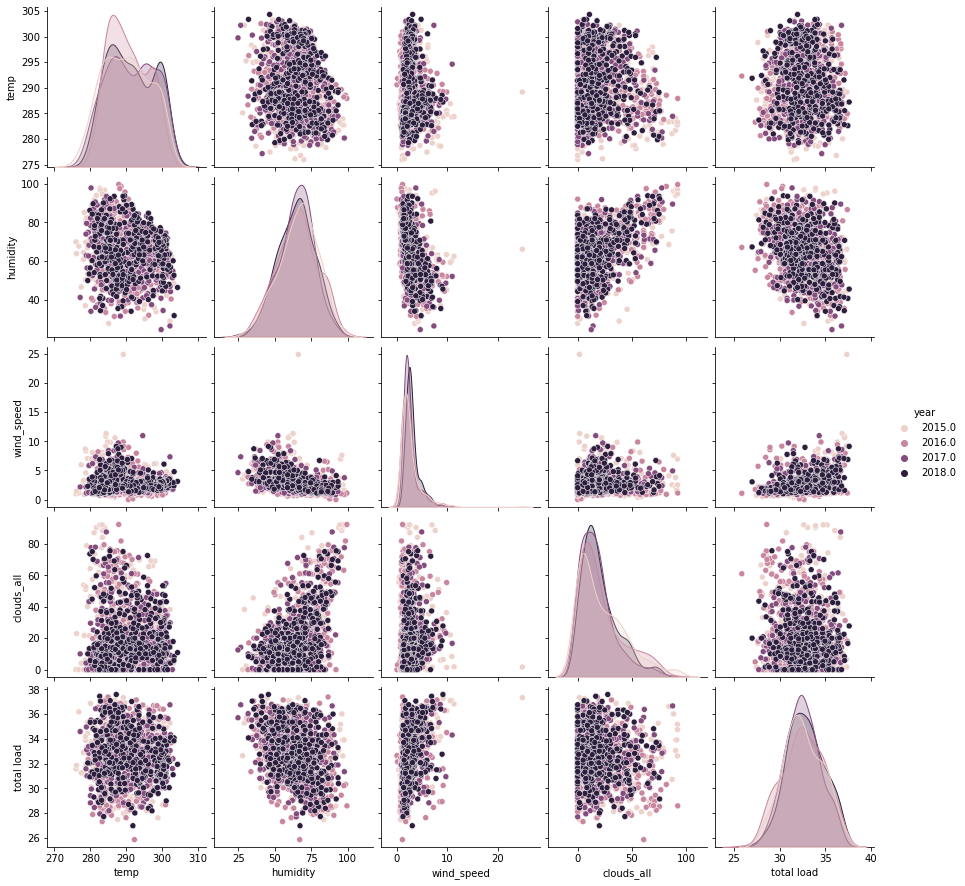

In [19]:
sns.pairplot(Daily, hue='year', vars=['temp','humidity','wind_speed','clouds_all','total load'])

### Model choice and validation

I create a pipeline with standard scaling and regression and then use it for **k-fold cross validation**. The folds are selected based on the year.

In [20]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [21]:
years = Daily['year'].copy()
X = Daily.drop(columns=['year','total load'])
y = Daily['total load'].copy()

In [22]:
kf = GroupKFold(n_splits=4)
estimator = Pipeline([("scaler", StandardScaler()),
                      ("regression", LinearRegression())])
predictions = cross_val_predict(estimator, X, y, groups=years, cv=kf)
print(r2_score(y, predictions))

0.11811557991400368


A plain linear model has little prediction skill.

I try adding **polynomial features** of 2nd degree to the pipeline:

In [23]:
estimator = Pipeline([("scaler", StandardScaler()),
                      ("polynomial", PolynomialFeatures(degree=2)),
                      ("regression", LinearRegression())])
predictions = cross_val_predict(estimator, X, y, groups=years, cv=kf)
print(r2_score(y, predictions))

-0.30862485525211913


Clearly the polynomial features did not help, actually made things worse probably because of overfitting.

Now I try with **Lasso**. For that I need to find the best hyperparameter alpha. I use GridSearchCV, also to figure out whether polynomial features are useful.

In [24]:
from sklearn.model_selection import GridSearchCV
estimator = Pipeline([("scaler", StandardScaler()),
                      ("polynomial", PolynomialFeatures()),
                      ("regression", Lasso(max_iter=50000))])
params = {
    'polynomial__degree': [1, 2],
    'regression__alpha': np.geomspace(1e-3, 1e+3, num=7)
}
grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X, y, groups=years)
grid.best_score_, grid.best_params_

(0.13409861179466867, {'polynomial__degree': 1, 'regression__alpha': 0.1})

Even with Lasso the skill is very low.

Let's check which features are actually used:

In [25]:
dict(zip(list(range(len(X.columns.values))), X.columns.values))

{0: 'temp',
 1: 'humidity',
 2: 'wind_speed',
 3: 'clouds_all',
 4: 'weather_main_clouds',
 5: 'weather_main_drizzle',
 6: 'weather_main_fog',
 7: 'weather_main_haze',
 8: 'weather_main_mist',
 9: 'weather_main_rain',
 10: 'weather_main_smoke',
 11: 'weather_main_thunderstorm'}

In [26]:
df_importances = pd.DataFrame(zip(grid.best_estimator_.named_steps["polynomial"].get_feature_names(),
                 np.absolute(grid.best_estimator_.named_steps["regression"].coef_),
))
df_importances.sort_values(by=1, ascending=False).head(20)

,0,1
3,x2,0.461088
2,x1,0.421050
1,x0,0.023037
10,x9,0.002689
0,1,0.000000
4,x3,0.000000
5,x4,0.000000
6,x5,0.000000
7,x6,0.000000
8,x7,0.000000


Wind speed (x2) and humidity (x1) are the only relevant predictors. None of the other features are really useful.